In [ ]:
!pip install tensorflow==2.10.0
!pip install Keras-Applications=== 1.0.7
!pip install image-classifiers == 1.0
!pip install efficientnet == 1.0
!pip install patchify


In [ ]:
!pip install -U segmentation-models

Segmentation Models - это библиотека глубокого обучения, предназначенная для решения задач сегментации. Она предоставляет набор высокоуровневых моделей, которые можно легко настроить и обучить для решения конкретной задачи сегментации.

Основые возможности библиотеки:

Легкость в использовании и установке
Поддержка различных архитектур CNN, таких как U-Net, FPN, PSPNet и др.
Реализация различных функций потерь и метрик оценки качества моделей
Гибкие настройки обучения и аугментации данных
Поддержка мульти-канальных входных данных и различных форматов изображений
Инструменты визуализации и интерпретации результатов

In [3]:
import segmentation_models as sm
import tensorflow as tf
from tensorflow import keras 

Segmentation Models: using `keras` framework.


In [4]:
import os
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
from google.colab import drive
!gdown "https://drive.google.com/u/0/uc?id=1UujK-kXOhCcjMt0S5OJIcu7SNWyGFEsy&export=download" 
!unzip "archive (1).zip"


In [ ]:
!gdown https://drive.google.com/uc?id=1--fNMFRXmBRDQPwdFqh54Sx7_RNE6z4a&confirm=t

In [37]:
!unzip image_RGB.zip


Archive:  image_RGB.zip
 extracting: image_RGB/GF2_PMS1__L1A0001064454-MSS1.tif  
 extracting: image_RGB/GF2_PMS1__L1A0001118839-MSS1.tif  
 extracting: image_RGB/GF2_PMS1__L1A0001395956-MSS1.tif  
 extracting: image_RGB/GF2_PMS1__L1A0001680858-MSS1.tif  
 extracting: image_RGB/GF2_PMS2__L1A0000718813-MSS2.tif  
 extracting: image_RGB/GF2_PMS2__L1A0001378501-MSS2.tif  
 extracting: image_RGB/GF2_PMS2__L1A0001471436-MSS2.tif  
 extracting: image_RGB/GF2_PMS2__L1A0001517494-MSS2.tif  
 extracting: image_RGB/GF2_PMS2__L1A0001787564-MSS2.tif  
 extracting: image_RGB/GF2_PMS2__L1A0001821754-MSS2.tif  


In [7]:
import cv2
import matplotlib.patches as mpatches
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import segmentation_models as sm
import tqdm
import tensorflow  as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from tensorflow.keras.metrics import MeanIoU, IoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from collections import Counter
from tensorflow.experimental.numpy import ravel
from tensorflow import stack, cast, int32, make_ndarray

In [8]:
BACKBONE = 'mobilenet'

preprocess_input = sm.get_preprocessing(BACKBONE)
BATCH_SIZE = 64
SEED = 42
RAW_N_CLASSES = 16
N_CLASSES = 14

In [9]:
import tensorflow  as tf

Функция merge_classes принимает на вход маску, два значения классов (cls1 и cls2) и общее количество классов (raw_num_classes) и объединяет класс cls1 с классом cls2 в этой маске. Затем она проходит в цикле по всем оставшимся классам, большим cls1, и сдвигает их вниз на 1, чтобы заполнить пробел, оставшийся после объединенных классов.

preprocess_data принимает на вход изображение (img), маску и количество классов (num_class). Она вызывает функцию merge_classes несколько раз, чтобы объединить некоторые классы в маске, преобразует маску в категориальный формат, используя to_categorical из Keras, и возвращает предобработанные изображение и маску.

trainGenerator является функцией-генератором, принимающей путь кображениям обучающей выборки, путь к маскам обучающей выборки, количество классов и некоторые параметры, такие как аугментация и отображение исходных или обработанных данных. Она сначала настраивает генераторы изображений и масок, затем объединяет их вместе, чтобы создать генератор обучения. Каждая итерация генератора обучения выдает набор предобработанных изображений и масок с помощью preprocess_data. Если включен параметр show_raw, она также возвращает стек исходных и обработанных изображений, чтобы их можно было отобразить позже.

show_mask_with_label является вспомогательной функцией, принимающей на вход набор масок (batch), список названий меток для каждого класса (labels), минимальное и максимальное значения для цветовой карты (_min и _max) и значение альфа-канала для прозрачности (alpha). Она сначала определяет уникальные значения в маске и их количество пикселей. Затем она создает цветовую карту на основе уникальных значений и связанных с ними меток и показывает ее с определенным минимальным и максимальным значениями и прозрачностью. Она также добавляет легенду на основе меток и количества пикселей и отображает метки только для классов с количеством, превышающим 0,005.

In [22]:
def merge_classes(mask, cls1, cls2, raw_num_classes=RAW_N_CLASSES):
    mask[mask == cls1] = cls2
    for i in range(cls1 + 1, raw_num_classes):
        mask[mask==i] = i - 1
    return mask

def preprocess_data(img, mask, num_class):
    img = preprocess_input(img)
    
    # merge some classes
    mask = merge_classes(mask, 7, 6)
    mask = merge_classes(mask, 13, 12)
    mask = to_categorical(mask, num_class)
    return (img, mask)

def trainGenerator(train_img_path, train_mask_path, num_class, aug=True, show_raw=False):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    if aug:
        image_datagen = ImageDataGenerator(**img_data_gen_args)
        mask_datagen = ImageDataGenerator(**img_data_gen_args)
    else:
        image_datagen = ImageDataGenerator()
        mask_datagen = ImageDataGenerator()
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = BATCH_SIZE,
        seed = SEED)
    print(image_generator)
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = BATCH_SIZE,
        seed = SEED)
    print(mask_generator)
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        if show_raw:
            raw_img = np.copy(img)
            img, mask = preprocess_data(img, mask, num_class)
            img = np.stack((img, raw_img), axis=-1)
            yield (img, mask)
        else:
            img, mask = preprocess_data(img, mask, num_class)
            yield (img, mask)


def show_mask_with_label(batch, labels, _min, _max, alpha=1):
    values, counts = np.unique(batch, return_counts=True)
    counts = counts / (256*256)
    im = plt.imshow(batch, cmap='viridis', vmin = _min, vmax = _max, alpha=alpha)
    colors = [im.cmap(im.norm(value)) for value in values]
    
    patches = [mpatches.Patch(color=colors[i], label=labels[values[i]]) \
               for i in range(len(values)) if counts[i] > 0.005]
    plt.legend(handles=patches)

In [24]:
kaggle_path = 'data/'
labels = ['background','industrial land',
          'urban residential','rural residential',
          'traffic land','paddy field','irrigated land', 'dry cropland',
          'garden plot','arbor woodland',
          'shrub land','natural grassland',
          'artificial grassland','river', 'lake','pond']

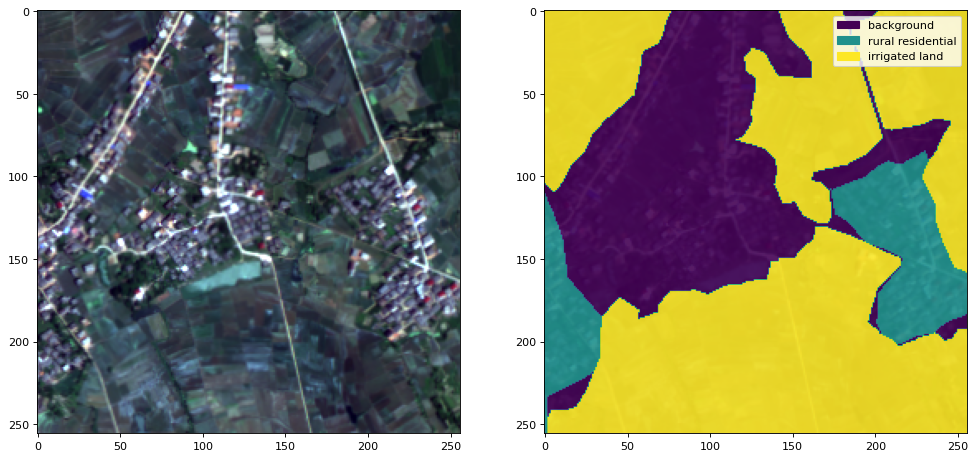

In [25]:
import random
train_img_dir = kaggle_path + "data_for_keras_aug/train_images/train/"
train_mask_dir = kaggle_path + "data_for_keras_aug/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

img_list.sort()
msk_list.sort()

num_images = len(os.listdir(train_img_dir))
img_num = random.randint(0, num_images - 1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot = cv2.imread(train_mask_dir+msk_list[img_num], 0)

_min, _max = np.amin(mask_for_plot), np.amax(mask_for_plot)

plt.figure(figsize=(15, 15), dpi=80)

plt.subplot(1,2,1)
plt.imshow(img_for_plot.astype('uint8'))

plt.subplot(1,2,2)
plt.imshow(img_for_plot.astype('uint8'))

plt.subplot(1,2,2)
show_mask_with_label(mask_for_plot, labels, _min, _max, alpha=0.9) # add some opacity  

plt.show()

In [27]:
train_img_path = kaggle_path + "data_for_keras_aug/train_images/"
train_mask_path = kaggle_path + "data_for_keras_aug/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=N_CLASSES)

val_img_path = kaggle_path + "data_for_keras_aug/val_images/"
val_mask_path = kaggle_path + "data_for_keras_aug/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=N_CLASSES)

Found 35292 images belonging to 1 classes.
Found 35292 images belonging to 1 classes.


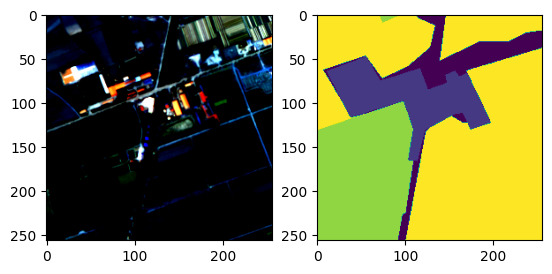

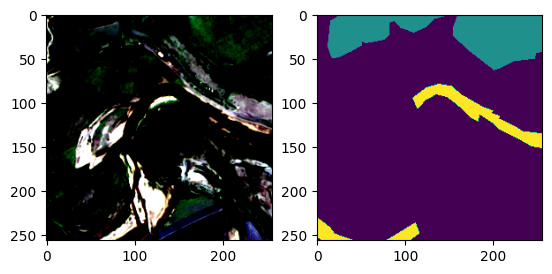

In [28]:
def show_examples(generator):
    x, y = generator.__next__()
    for i in range(0,2):
        image = x[i]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = np.argmax(y[i], axis=2)
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.subplot(1,2,2)
        plt.imshow(mask, cmap='viridis')
        plt.show()
    return x, y

x, y = show_examples(train_img_gen)

In [15]:
num_train_imgs = len(os.listdir(train_img_path + "/train"))
num_val_images = len(os.listdir(val_img_path + "/val"))

steps_per_epoch = num_train_imgs // BATCH_SIZE
val_steps_per_epoch = num_val_images // BATCH_SIZE

IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

In [16]:
from keras.models import load_model 


load_model() позволяет загрузить сохраненную модель, которая была обучена и сохранена на диск с помощью Keras. В данном случае, путь к файлу модели задается переменной s.

Затем модель компилируется с помощью метода compile(), которому передаются параметры оптимизатора (в данном случае - Adam), функция потерь (в данном случае - categorical_focal_jaccard_loss) и метрики (в данном случае - iou_score).

categorical_focal_jaccard_loss - это функция потерь, которая оптимизирует метрику IOU и учитывает категорические данные.

iou_score - это метрика, которая вычисляет межклассовую IoU для каждого класса в многоклассовой задаче сегментации.

После компиляции модели она готова к использованию для классификации новых изображений.

In [44]:
s='/content/drive/MyDrive/__epochs_ (1).h5'
model = load_model(s, compile=False)
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])



In [ ]:
history= model.fit(train_img_gen,
  steps_per_epoch=steps_per_epoch,
  epochs=10,
  verbose=1,
  validation_data=val_img_gen,
  validation_steps=val_steps_per_epoch)
model.save('/content/drive/MyDrive/__epoch4s_.h5')

Epoch 1/10
140/551 [======>.......................] - ETA: 8:30 - loss: 0.4138 - iou_score: 0.5991

In [ ]:
# !pip install tf2onnx
# onnx_model,_=tf2onnx.convert.from_keras(model)
# onnx.save(onnx_model,"model1.onnx")

Данный код использует модель для сегментации изображений и вычисляет среднюю метрику IoU (Intersection over Union) для тестовых данных. Метрика IoU показывает, насколько хорошо модель разделяет различные классы объектов на изображении.

В первых шести строках определяется генератор данных для валидационной выборки. В строке eval_preds_img_gen.__next__() генератор вызывается, чтобы получить очередной набор данных для оценки результатов модели.

Далее выполняется прогнозирование на этом наборе тестовых данных и вычисляется средняя метрика IoU для полученных результатов с помощью класса MeanIoU. Затем выбирается случайное изображение из тестового набора данных и отображаются три изображения в строковом формате: исходное изображение, маска, полученная из тестового набора, и маска, полученная в результате работы модели. Для отображения масок используется функция show_mask_with_label, которая выводит цветом каждый класс на изображении. Цвет каждого класса задается в labels, а соответствующий его номер получается с помощью test_pred_batch_argmax и test_mask_batch_argmax.

Далее генератор вызывается снова, чтобы получить следующий набор данных для оценки результатов модели. Обновляется значение метрики IoU и выбирается новое случайное изображение для вывода результатов. Все эти шаги повторяются несколько раз, чтобы оценить качество работы модели на различных тестовых данных.





In [29]:
eval_preds_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=N_CLASSES, show_raw=True)
test_image_batch, test_mask_batch = eval_preds_img_gen.__next__()
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
print(test_image_batch.shape)
test_pred_batch = model.predict(test_image_batch[:, :, :, :, 0])
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)


IOU_keras = MeanIoU(num_classes=N_CLASSES, ignore_class=[0]) 
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

img_num = random.randint(0, test_image_batch.shape[0]-4)

for i in range(0, 10):
  combined_data = np.array(list(np.unique(test_mask_batch_argmax[img_num+i])) + list(np.unique(test_pred_batch_argmax[img_num+i])))
  _min, _max = np.amin(combined_data), np.amax(combined_data)
  plt.figure(figsize=(15, 15), dpi=80)

  plt.subplot(1,3,1)
  plt.imshow(test_image_batch[:, :, :, :, 1][img_num+i].astype('uint8'))

  plt.subplot(1,3,2)
  plt.imshow(test_image_batch[:, :, :, :, 1][img_num+i].astype('uint8'))
  plt.subplot(1,3,2)
  show_mask_with_label(test_mask_batch_argmax[img_num+i], labels, _min, _max, alpha=0.9)

  plt.subplot(1,3,3)
  show_mask_with_label(test_pred_batch_argmax[img_num+i], labels, _min, _max)
  plt.show()
  test_image_batch, test_mask_batch = eval_preds_img_gen.__next__()
  test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)

  test_pred_batch = model.predict(test_image_batch[:, :, :, :, 0])
  print(test_image_batch.shape)
  test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)


  IOU_keras = MeanIoU(num_classes=N_CLASSES, ignore_class=[0]) # you can ignore "background" class
  IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
  print("Mean IoU =", IOU_keras.result().numpy())

  img_num = random.randint(0, test_image_batch.shape[0]-4)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from keras.utils import normalize
from PIL import Image


In [ ]:
!pip install image-utils

1/1 [==============================] - 0s 26ms/step


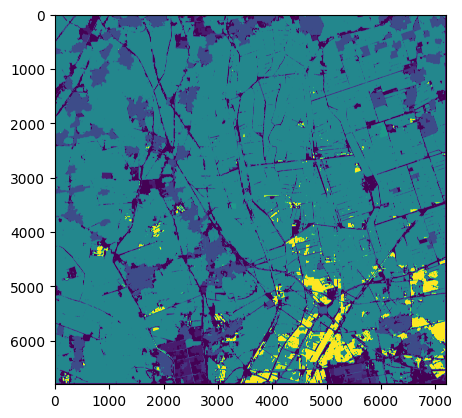

In [42]:
import cv2
import numpy as np

def prediction( img, patch_size):
 # Define stride size and image size for each patch
 stride_size = 128
 patch_size = 256
 # Create empty mask image
 mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
 # Loop through image patches
 for i in range(0, img.shape[0]-patch_size+1, stride_size):
    for j in range(0, img.shape[1]-patch_size+1, stride_size):
        # Extract image patch
        img_patch = img[i:i+patch_size, j:j+patch_size,:]
        # Preprocess the patch
        img_patch = preprocess_input(img_patch)
        img_patch = np.expand_dims(img_patch, axis=0)
        # Get prediction from model
        pred_mask = model.predict(img_patch)
        pred_mask = np.argmax(pred_mask, axis=3)[0].astype('uint8')
        # Resize mask to patch size
        pred_mask = cv2.resize(pred_mask, (patch_size, patch_size))
        # Update mask with patch
        mask[i:i+patch_size, j:j+patch_size] = pred_mask
 import tifffile
 plt.imshow(mask)
 plt.show()
 tifffile.imwrite('image.tif', mask)
 return mask
img = cv2.imread("/content/image_RGB/GF2_PMS1__L1A0001064454-MSS1.tif") 
 
mask=prediction(img,256)

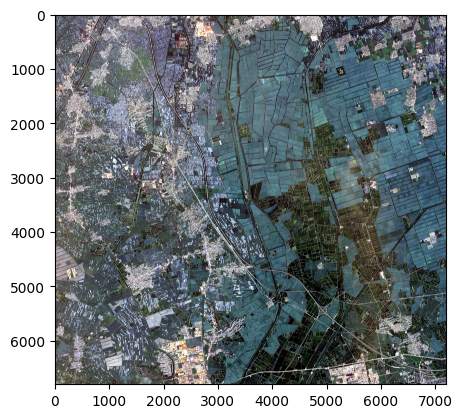

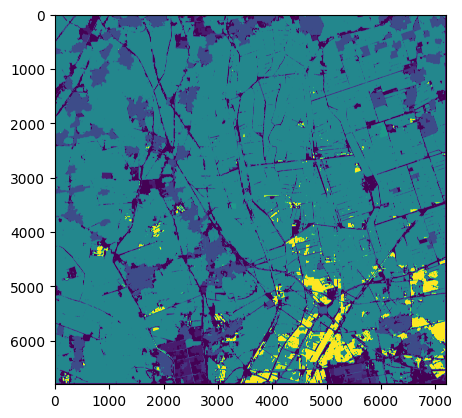

In [43]:
plt.imshow(img)
plt.show()
plt.imshow(mask)
plt.show()

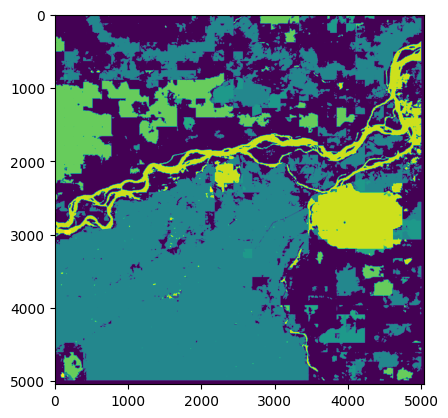

In [ ]:
plt.imshow(img)
plt.show()
plt.imshow(mask)
plt.show()